In [6]:
import gzip
import shutil

# Rule: Ensure the correct path for the input and output files.
with gzip.open('CAD_META.gz', 'rb') as f_in:
    with open('CAD_META.txt', 'wb') as f_out:
        shutil.copyfileobj(f_in, f_out)

print("GWAS summary data decompressed successfully.")


GWAS summary data decompressed successfully.


In [10]:
import pandas as pd

# Define file path for decompressed file
Genetic_Data_Summary = "C:/Users/emman/Downloads/PM2.5_Pollution_Data-Public/Scripts/Genetic_Data/New_Genetic_Data/CAD_META.txt"  # Replace with your actual path

# Try reading the file in chunks if it's too large
chunk_size = 10000  # Number of rows per chunk
chunks = pd.read_csv(Genetic_Data_Summary, delimiter='\t', chunksize=chunk_size, engine='python')  # Removed low_memory

# Concatenate chunks into a single DataFrame
genetic_df = pd.concat(chunks, ignore_index=True)

# Display first 10 rows to verify loading
print(genetic_df.head(10))

# Display columns to understand dataset structure
print(genetic_df.columns)
print(genetic_df.shape)

# Get basic info on data types and non-null counts
print(genetic_df.info())

# Rule: Clean the data by removing rows with missing critical data and filter significant variants.
# Use 'MarkerName' and 'P-value' instead of 'SNP' and 'P'
genetic_df_cleaned = genetic_df.dropna(subset=['MarkerName', 'Effect', 'P-value'])  # Remove missing critical data
significant_genetic_df = genetic_df_cleaned[genetic_df_cleaned['P-value'] < 5e-8]  # Filter by p-value threshold

# Save cleaned data for future use
significant_genetic_df.to_csv('significant_genetic_data.csv', index=False)
print("Data cleaned and significant SNPs extracted.")

         MarkerName Allele1 Allele2   Freq1  FreqSE  MinFreq  MaxFreq  Effect  \
0  10:100000625_A_G       a       g  0.5604  0.0081   0.5499   0.5667  0.0264   
1  10:100000645_A_C       a       c  0.8060  0.0089   0.7996   0.8184 -0.0119   
2  10:100001867_C_T       t       c  0.0129  0.0007   0.0114   0.0132  0.0296   
3  10:100003242_G_T       t       g  0.8800  0.0034   0.8756   0.8827  0.0107   
4  10:100003304_A_G       a       g  0.9636  0.0037   0.9615   0.9701  0.0066   
5  10:100003785_C_T       t       c  0.6432  0.0006   0.6425   0.6437 -0.0203   
6  10:100004360_A_G       a       g  0.1939  0.0090   0.1814   0.2004  0.0120   
7  10:100004441_C_G       c       g  0.6328  0.0029   0.6290   0.6350 -0.0196   
8  10:100004799_A_C       a       c  0.9863  0.0014   0.9857   0.9891 -0.0185   
9  10:100004906_A_C       a       c  0.4395  0.0081   0.4332   0.4500 -0.0265   

   StdErr   P-value Direction  HetISq  HetChiSq  HetDf  HetPVal        oldID  \
0  0.0056  0.000003        +

In [11]:
import requests

# Step 1: Download the panel file (if you haven't downloaded manually)
url = 'https://ftp.1000genomes.ebi.ac.uk/vol1/ftp/release/20130502/integrated_call_samples_v3.20130502.ALL.panel'
panel_file = 'integrated_call_samples_v3.20130502.ALL.panel'

response = requests.get(url)
with open(panel_file, 'wb') as f:
    f.write(response.content)

print("Panel file downloaded!")

# Step 2: Read panel file and extract GBR sample IDs
panel_df = pd.read_csv(panel_file, sep='\t')
gbr_samples = panel_df[panel_df['pop'] == 'GBR']
gbr_sample_ids = gbr_samples['sample'].tolist()

# Save GBR sample IDs to a file
with open('GBR_sample_ids.txt', 'w') as f:
    for sample_id in gbr_sample_ids:
        f.write(sample_id + '\n')

print(f"Found {len(gbr_sample_ids)} GBR samples.")
print(gbr_sample_ids[:10])


Panel file downloaded!
Found 91 GBR samples.
['HG00096', 'HG00097', 'HG00099', 'HG00100', 'HG00101', 'HG00102', 'HG00103', 'HG00105', 'HG00106', 'HG00107']


In [12]:
import pandas as pd

# Load sample metadata (population info, sample IDs)
samples = pd.read_csv('integrated_call_samples_v3.20130502.ALL.panel', sep='\t')
print(samples.head())

# Columns usually: sample, population, super_population, gender


    sample  pop super_pop  gender  Unnamed: 4  Unnamed: 5
0  HG00096  GBR       EUR    male         NaN         NaN
1  HG00097  GBR       EUR  female         NaN         NaN
2  HG00099  GBR       EUR  female         NaN         NaN
3  HG00100  GBR       EUR  female         NaN         NaN
4  HG00101  GBR       EUR    male         NaN         NaN


In [2]:
import pandas as pd
import allel# From scikit-allel: for VCF parsing and genotype analysis
import os# For file path and existence checks

# File paths
vcf_path = r"ALL.chr1.phase3_shapeit2_mvncall_integrated_v5b.20130502.genotypes (1).vcf.gz"
samples_path = "integrated_call_samples_v3.20130502.ALL.panel"
output_file = "allele_freq_chr1.csv.gz"  # Output will be compressed CSV

print("VCF file exists:", os.path.exists(vcf_path))#Check VCF File Exists

# Load samples info and filter EUR samples
samples_df = pd.read_csv(samples_path, sep="\t")## Load sample panel
eur_samples = samples_df[samples_df['super_pop'] == 'EUR']['sample'].tolist()#Loads metadata and filters for European ancestry samples

# Prepare chunk parameters
chunk_size = 50_000 #Number of variants per chunk
chrom = '1' #Target chromosome

# Read all positions for chromosome 1 to identify variant locations.
vcf_all_pos = allel.read_vcf(vcf_path, fields=['variants/CHROM', 'variants/POS'])
positions = vcf_all_pos['variants/POS']
chroms = vcf_all_pos['variants/CHROM']

# Filter chromosome 1 positions and Create a mask for chromosome 1 and filters positions accordingly.
chr1_mask = chroms == chrom
chr1_positions = positions[chr1_mask]

# Remove old output file if exists
if os.path.exists(output_file):
    os.remove(output_file)

# Iterate and write chunks directly to CSV
start_idx = 0#Initializes loop variables
first_chunk = True
total_variants_chr1 = len(chr1_positions)#calculates total number of variants.

# Batch size for writing to disk to reduce I/O frequency
batch_size = 10  # Number of chunks to process before saving

while start_idx < total_variants_chr1:#Loops through all variants in chunks.
    end_idx = min(start_idx + chunk_size, total_variants_chr1)
    start_pos = chr1_positions[start_idx]#Calculates start/end positions and formats region string for VCF slicing.
    end_pos = chr1_positions[end_idx - 1]

    region_str = f"{chrom}:{start_pos}-{end_pos}"
    print(f"Processing region: {region_str}")

    #Read VCF Chunk
    chunk = allel.read_vcf(
        vcf_path,
        samples=eur_samples,
        region=region_str,
        fields=['variants/CHROM', 'variants/POS', 'variants/REF', 'variants/ALT', 'calldata/GT'],
        alt_number=1
    )#Loads genotype and variant data for the specified region and EUR samples.

    #Skip Empty Chunks
    if chunk is None or len(chunk['variants/POS']) == 0:
        start_idx = end_idx
        continue#Skips processing if no variants were found in the chunk.

    genotypes = allel.GenotypeArray(chunk['calldata/GT'])## Convert to GenotypeArray
    allele_counts = genotypes.count_alleles()## Count alleles per variant
    alt_freqs = allele_counts[:, 1] / allele_counts.sum(axis=1)## ALT allele frequency

    alts = chunk['variants/ALT']
    if alts.ndim == 2:
        alts = alts[:, 0]#If ALT alleles are stored as 2D arrays (e.g., multiple alleles), extract the first.

    #Create DataFrame for Chunk
    df_chunk = pd.DataFrame({
        'chr': chunk['variants/CHROM'],
        'pos': chunk['variants/POS'],
        'ref': chunk['variants/REF'],
        'alt': alts,
        'alt_freq_eur': alt_freqs
    })

    # Write chunks in batches
    if (start_idx // chunk_size) % batch_size == 0:
        # Save all chunks in batch to CSV
        df_chunk.to_csv(output_file, mode='a', header=first_chunk, index=False, compression='gzip')
        first_chunk = False

    start_idx = end_idx

print(f"✅ Finished saving to {output_file}")


VCF file exists: True
Processing region: 1:10177-1922199
Processing region: 1:1922223-3231709
Processing region: 1:3231710-4703091
Processing region: 1:4703101-6122675
Processing region: 1:6122681-7682431
Processing region: 1:7682434-9331783
Processing region: 1:9331786-10980208
Processing region: 1:10980235-12573799
Processing region: 1:12573823-14749483
Processing region: 1:14749491-16318356
Processing region: 1:16318421-17981187
Processing region: 1:17981244-19504756
Processing region: 1:19504773-21119234
Processing region: 1:21119276-22792865
Processing region: 1:22792895-24606967
Processing region: 1:24607029-26361914
Processing region: 1:26361923-28212192
Processing region: 1:28212209-30167343
Processing region: 1:30167376-31702234
Processing region: 1:31702238-33494458
Processing region: 1:33494566-35218091
Processing region: 1:35218133-37029372
Processing region: 1:37029383-38695461
Processing region: 1:38695486-40478261
Processing region: 1:40478303-42256317
Processing region:

In [ ]:
output_file = r"C:/Users/emman/Downloads/PM2.5_Pollution_Data-Public/Scripts/Genetic_Data/New_Genetic_Data/allele_freq_chr1.csv.gz"  # Replace with your desired location

In [54]:
import pandas as pd

# Load the compressed allele frequency file with low_memory=False to avoid dtype warnings
allele_freq_df = pd.read_csv('allele_freq_chr1.csv.gz', compression='gzip', low_memory=False)

# Now assign column names manually
allele_freq_df.columns = ['chr', 'pos', 'ref', 'alt', 'alt_freq']

# Print the first few rows of the dataset
print(allele_freq_df.head())
print(allele_freq_df.columns)
print(allele_freq_df.shape)




  chr      pos ref alt               alt_freq
0   1  2172269   C   T  0.0009940357852882703
1   1  2172295   A   C                    0.0
2   1  2172355   G   A                    0.0
3   1  2172432   C   T  0.0009940357852882703
4   1  2172437   G   T                    0.0
Index(['chr', 'pos', 'ref', 'alt', 'alt_freq'], dtype='object')
(1800000, 5)


In [55]:
import pandas as pd
# Define the path to your gzipped scoring file
pgs_scoring_file = "C:/Users/emman/Downloads/PM2.5_Pollution_Data-Public/Scripts/Genetic_Data/New_Genetic_Data/PGS000018.txt.gz"

#Load the file using pandas with robust settings
pgs_df = pd.read_csv(
    pgs_scoring_file, ## File path
    sep='\t', ## Tab-separated values
    compression='gzip', ## File is gzipped
    comment='#',         # Skip all comment lines starting with '#'
    engine='python', # More tolerant parser than default 'c'
    on_bad_lines='skip' # Skip malformed lines instead of raising errors
)

#Display the first few rows of the parsed DataFrame
print(pgs_df.head())
print(pgs_df.columns)
print(pgs_df.shape)



         rsID  chr_name  chr_position effect_allele other_allele  \
0   rs2843152         1       2245570             G            C   
1  rs35465346         1      22132518             G            A   
2  rs28470722         1      38386727             G            A   
3  rs11206510         1      55496039             T            C   
4   rs9970807         1      56965664             C            T   

   effect_weight  
0      -0.027601  
1       0.023934  
2      -0.017493  
3       0.029301  
4       0.047003  
Index(['rsID', 'chr_name', 'chr_position', 'effect_allele', 'other_allele',
       'effect_weight'],
      dtype='object')
(1745179, 6)


In [56]:
print("Genetic Data Columns:", significant_genetic_df.columns.tolist())
print("PGS Columns:", pgs_df.columns.tolist())
print(significant_genetic_df.shape)


Genetic Data Columns: ['MarkerName', 'Allele1', 'Allele2', 'Freq1', 'FreqSE', 'MinFreq', 'MaxFreq', 'Effect', 'StdErr', 'P-value', 'Direction', 'HetISq', 'HetChiSq', 'HetDf', 'HetPVal', 'oldID', 'CHR', 'BP']
PGS Columns: ['rsID', 'chr_name', 'chr_position', 'effect_allele', 'other_allele', 'effect_weight']
(10118, 18)


In [59]:
# Rule: Use a robust merge strategy to combine genetic data with PGS
def merge_datasets(significant_genetic_df, pgs_df, left_col="oldID", right_col="rsID", how="inner"):
    # Ensure both columns exist before merging
    if left_col not in genetic_df.columns:
        raise KeyError(f"❌ Column '{left_col}' not found in genetic data")
    if right_col not in pgs_df.columns:
        raise KeyError(f"❌ Column '{right_col}' not found in PGS scoring data")
    
    # Perform the merge
    merged = pd.merge(significant_genetic_df, pgs_df, left_on=left_col, right_on=right_col, how=how)
    
    print(f"✅ Merge complete: {merged.shape[0]} rows, {merged.shape[1]} columns")
    return merged

# Merge GWAS data with PGS
merged_siggensummaryXprs_df = merge_datasets(significant_genetic_df, pgs_df)
print(merged_siggensummaryXprs_df.head())
print(merged_siggensummaryXprs_df.shape)


✅ Merge complete: 1405 rows, 24 columns
         MarkerName Allele1 Allele2   Freq1  FreqSE  MinFreq  MaxFreq  Effect  \
0  10:104604916_G_T       t       g  0.8895  0.0190   0.8715   0.9095  0.0579   
1  10:104616663_C_T       t       c  0.8779  0.0251   0.8556   0.9061  0.0577   
2  10:104628234_C_T       t       c  0.8819  0.0281   0.8518   0.9082  0.0647   
3  10:104636655_C_G       c       g  0.1591  0.0169   0.1419   0.1756 -0.0397   
4  10:104652323_C_T       t       c  0.1063  0.0197   0.0843   0.1240 -0.0658   

   StdErr       P-value  ...  HetPVal       oldID  CHR         BP        rsID  \
0  0.0085  9.181000e-12  ...  0.41140  rs11191416   10  104604916  rs11191416   
1  0.0081  8.495000e-13  ...  0.15160   rs4409766   10  104616663   rs4409766   
2  0.0089  4.490000e-13  ...  0.03088   rs7098825   10  104628234   rs7098825   
3  0.0071  2.008000e-08  ...  0.03632   rs3740393   10  104636655   rs3740393   
4  0.0085  8.723000e-15  ...  0.27210  rs11191447   10  104652323  r

In [40]:
print(allele_freq_df['pos'].unique())  # See unique values in 'pos'
print(allele_freq_df.iloc[0])


['2172269' '2172295' '2172355' ... '40850011' '40850047' '40850085']
chr                             1
pos                       2172269
ref                             C
alt                             T
alt_freq    0.0009940357852882703
Name: 0, dtype: object


In [60]:
import pandas as pd

def merge_with_allele_freq(merged_siggensummaryXprs_df, allele_freq_df, left_cols=('CHR', 'BP'), right_cols=('chr', 'pos'), how='inner'):
    # Ensure inputs are DataFrames
    if not isinstance(merged_siggensummaryXprs_df, pd.DataFrame):
        raise TypeError("❌ 'merged_df' must be a pandas DataFrame")
    if not isinstance(allele_freq_df, pd.DataFrame):
        raise TypeError("❌ 'allele_freq_df' must be a pandas DataFrame")
    
    # Check required columns exist in both DataFrames
    for col in left_cols:
        if col not in merged_siggensummaryXprs_df.columns:
            raise KeyError(f"❌ Column '{col}' not found in merged_df")
    for col in right_cols:
        if col not in allele_freq_df.columns:
            raise KeyError(f"❌ Column '{col}' not found in allele_freq_df")
    
    # Harmonize chromosome format (remove 'chr' prefix if needed)
    merged_siggensummaryXprs_df[left_cols[0]] = merged_siggensummaryXprs_df[left_cols[0]].astype(str).str.replace('chr', '', case=False)
    allele_freq_df[right_cols[0]] = allele_freq_df[right_cols[0]].astype(str).str.replace('chr', '', case=False)

    #Drop header row if it exists inside allele_freq_df data ---
    if allele_freq_df.iloc[0].astype(str).str.lower().isin(['chr', 'pos', 'ref', 'alt', 'alt_freq']).all():
        allele_freq_df = allele_freq_df.drop(allele_freq_df.index[0]).reset_index(drop=True)
    
    # Safely convert positions to numeric with coercion and drop invalid rows
    merged_siggensummaryXprs_df[left_cols[1]] = pd.to_numeric(merged_siggensummaryXprs_df[left_cols[1]], errors='coerce')
    allele_freq_df[right_cols[1]] = pd.to_numeric(allele_freq_df[right_cols[1]], errors='coerce')
    
    # Remove rows with NaN values in the columns used for merging (optional but recommended)
    merged_siggensummaryXprs_df = merged_siggensummaryXprs_df.dropna(subset=left_cols)
    allele_freq_df = allele_freq_df.dropna(subset=right_cols)
    
    # Merge the data
    full_merged_siggensummaryXprs_df = pd.merge(merged_siggensummaryXprs_df, allele_freq_df, left_on=left_cols, right_on=right_cols, how=how)
    
    print(f"✅ Merge complete: {full_merged_siggensummaryXprs_df.shape[0]} rows, {full_merged_siggensummaryXprs_df.shape[1]} columns")
    print("\n📄 Preview:")
    print(full_merged_siggensummaryXprs_df.head())
    
    return full_merged_siggensummaryXprs_df

# Example usage:
# Rename columns of allele_freq_df to match expectations
allele_freq_df.columns = ['chr', 'pos', 'ref', 'alt', 'alt_freq']  # Rename columns accordingly

# Now you can safely call the merge function
merged_siggensummaryXprs_and_allele_freq_df = merge_with_allele_freq(merged_siggensummaryXprs_df, allele_freq_df, ('CHR', 'BP'), ('chr', 'pos'), 'inner')


✅ Merge complete: 10 rows, 29 columns

📄 Preview:
        MarkerName Allele1 Allele2   Freq1  FreqSE  MinFreq  MaxFreq  Effect  \
0  1:200646073_C_T       t       c  0.4715  0.0018   0.4697   0.4733 -0.0284   
1    1:2252191_A_G       a       g  0.7811  0.0059   0.7728   0.7853 -0.0395   
2    1:2252205_C_T       t       c  0.1483  0.0038   0.1428   0.1509  0.0469   
3    1:2990994_C_T       t       c  0.3794  0.0090   0.3733   0.3925  0.0341   
4    1:3328659_C_T       t       c  0.1381  0.0002   0.1379   0.1382  0.0436   

   StdErr       P-value  ... chr_name  chr_position  effect_allele  \
0  0.0050  1.769000e-08  ...        1     200646073              C   
1  0.0071  2.978000e-08  ...        1       2252191              A   
2  0.0082  1.326000e-08  ...        1       2252205              C   
3  0.0061  2.792000e-08  ...        1       2990994              C   
4  0.0075  7.582000e-09  ...        1       3328659              C   

   other_allele  effect_weight chr          pos 

In [72]:
# Save the merged DataFrame to a compressed CSV file
merged_siggensummaryXprs_and_allele_freq_df.to_csv('merged_siggensummaryXprs_and_allele_freq_data.csv.gz', index=False, compression='gzip')
print(merged_siggensummaryXprs_and_allele_freq_df.shape)

(10, 29)


In [71]:
import pandas as pd
print(merged_siggensummaryXprs_and_allele_freq_df.head()) == pd.read_csv('merged_siggensummaryXprs_and_allele_freq_data.csv.gz', compression='gzip')

print(merged_siggensummaryXprs_and_allele_freq_df.shape)

        MarkerName Allele1 Allele2   Freq1  FreqSE  MinFreq  MaxFreq  Effect  \
0  1:200646073_C_T       t       c  0.4715  0.0018   0.4697   0.4733 -0.0284   
1    1:2252191_A_G       a       g  0.7811  0.0059   0.7728   0.7853 -0.0395   
2    1:2252205_C_T       t       c  0.1483  0.0038   0.1428   0.1509  0.0469   
3    1:2990994_C_T       t       c  0.3794  0.0090   0.3733   0.3925  0.0341   
4    1:3328659_C_T       t       c  0.1381  0.0002   0.1379   0.1382  0.0436   

   StdErr       P-value  ... chr_name  chr_position  effect_allele  \
0  0.0050  1.769000e-08  ...        1     200646073              C   
1  0.0071  2.978000e-08  ...        1       2252191              A   
2  0.0082  1.326000e-08  ...        1       2252205              C   
3  0.0061  2.792000e-08  ...        1       2990994              C   
4  0.0075  7.582000e-09  ...        1       3328659              C   

   other_allele  effect_weight chr          pos  ref alt             alt_freq  
0             T   

In [75]:
# Check if 'alt_freq' is in the columns of the merged DataFrame
print(merged_siggensummaryXprs_and_allele_freq_df.columns)


Index(['MarkerName', 'Allele1', 'Allele2', 'Freq1', 'FreqSE', 'MinFreq',
       'MaxFreq', 'Effect', 'StdErr', 'P-value', 'Direction', 'HetISq',
       'HetChiSq', 'HetDf', 'HetPVal', 'oldID', 'CHR', 'BP', 'rsID',
       'chr_name', 'chr_position', 'effect_allele', 'other_allele',
       'effect_weight', 'chr', 'pos', 'ref', 'alt', 'alt_freq'],
      dtype='object')


In [80]:
# Calculate Polygenic Risk Score (PRS) based on effect sizes and allele frequencies
# Assuming 'Effect' is the effect size and 'alt_freq' is the frequency of the alternative allele

# Rule: Calculate PRS using the formula
# PRS = sum(Effect_i * 2 * AltFreq_i) for each SNP

# Ensure the columns are numeric and handle any non-numeric values
merged_siggensummaryXprs_and_allele_freq_df['Effect'] = pd.to_numeric(merged_siggensummaryXprs_and_allele_freq_df['Effect'], errors='coerce')
merged_siggensummaryXprs_and_allele_freq_df['alt_freq'] = pd.to_numeric(merged_siggensummaryXprs_and_allele_freq_df['alt_freq'], errors='coerce')

# Calculate PRS using the formula: PRS = Effect * 2 * alt_freq
merged_siggensummaryXprs_and_allele_freq_df['PRS'] = merged_siggensummaryXprs_and_allele_freq_df['Effect'] * 2 * merged_siggensummaryXprs_and_allele_freq_df['alt_freq']

# Inspect the first few rows to ensure PRS is correctly calculated
print(merged_siggensummaryXprs_and_allele_freq_df[['MarkerName', 'Effect', 'alt_freq', 'PRS']].head())
print(merged_siggensummaryXprs_and_allele_freq_df.shape)
# Save the PRS values to a new file for further use
merged_siggensummaryXprs_and_allele_freq_df.to_csv('genetic_data_with_PRS.csv', index=False)

print("PRS calculation complete and saved to 'genetic_data_with_PRS.csv'.")


        MarkerName  Effect  alt_freq       PRS
0  1:200646073_C_T -0.0284  0.477137 -0.027101
1    1:2252191_A_G -0.0395  0.212724 -0.016805
2    1:2252205_C_T  0.0469  0.147117  0.013800
3    1:2990994_C_T  0.0341  0.382704  0.026100
4    1:3328659_C_T  0.0436  0.166004  0.014476
(10, 30)
PRS calculation complete and saved to 'genetic_data_with_PRS.csv'.


In [81]:
#To verify that the PRS values make sense, you can check the distribution of PRS values (mean, standard deviation, min, max, etc.).
print(merged_siggensummaryXprs_and_allele_freq_df['PRS'].describe())  # Get basic statistics of PRS


count    10.000000
mean     -0.000316
std       0.027539
min      -0.028149
25%      -0.027091
50%      -0.001503
75%       0.023194
max       0.039108
Name: PRS, dtype: float64


Interpretation and Next Steps:

The mean PRS being close to zero suggests that your SNPs have a balanced distribution of genetic risk, with no extreme shifts toward higher or lower genetic predisposition.

The standard deviation indicates that while most SNPs contribute modestly to PRS, there are some SNPs that contribute much more or less (which is expected given the wide range between the minimum and maximum PRS values).

Next Actions:

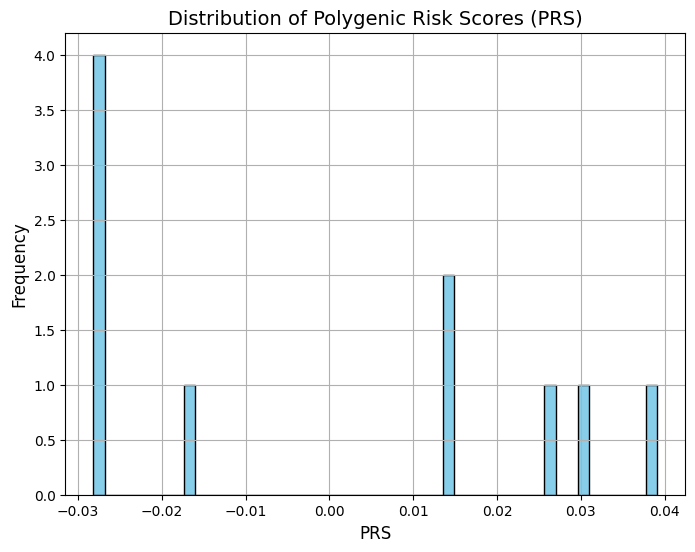

In [82]:
import matplotlib.pyplot as plt

# Plot histogram of PRS distribution
plt.figure(figsize=(8, 6))
plt.hist(merged_siggensummaryXprs_and_allele_freq_df['PRS'], bins=50, color='skyblue', edgecolor='black')
plt.title('Distribution of Polygenic Risk Scores (PRS)', fontsize=14)
plt.xlabel('PRS', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.grid(True)
plt.show()

#A histogram visualize the distribution of PRS values, showing the spread and any potential outliers.

In [83]:
# Identify rows with extreme PRS values
outliers = merged_siggensummaryXprs_and_allele_freq_df[merged_siggensummaryXprs_and_allele_freq_df['PRS'] < -0.05]  # Example for low outliers
print("Low PRS outliers:", outliers)

outliers = merged_siggensummaryXprs_and_allele_freq_df[merged_siggensummaryXprs_and_allele_freq_df['PRS'] > 0.05]  # Example for high outliers
print("High PRS outliers:", outliers)


Low PRS outliers: Empty DataFrame
Columns: [MarkerName, Allele1, Allele2, Freq1, FreqSE, MinFreq, MaxFreq, Effect, StdErr, P-value, Direction, HetISq, HetChiSq, HetDf, HetPVal, oldID, CHR, BP, rsID, chr_name, chr_position, effect_allele, other_allele, effect_weight, chr, pos, ref, alt, alt_freq, PRS]
Index: []

[0 rows x 30 columns]
High PRS outliers: Empty DataFrame
Columns: [MarkerName, Allele1, Allele2, Freq1, FreqSE, MinFreq, MaxFreq, Effect, StdErr, P-value, Direction, HetISq, HetChiSq, HetDf, HetPVal, oldID, CHR, BP, rsID, chr_name, chr_position, effect_allele, other_allele, effect_weight, chr, pos, ref, alt, alt_freq, PRS]
Index: []

[0 rows x 30 columns]


In [ ]:
#normalize the PRS values to standardize them across the dataset, especially if they will be used in a machine learning model.
# Normalize PRS to have zero mean and unit variance
merged_full_df['PRS_normalized'] = (merged_full_df['PRS'] - merged_full_df['PRS'].mean()) / merged_full_df['PRS'].std()

# Inspect the normalized PRS values
print(merged_full_df[['MarkerName', 'PRS', 'PRS_normalized']].head())


In [52]:
low_outliers = merged_full_df[merged_full_df['PRS'] < -0.05]
print(f"Number of low PRS outliers: {low_outliers.shape[0]}")

high_outliers = merged_full_df[merged_full_df['PRS'] > 0.05]
print(f"Number of high PRS outliers: {high_outliers.shape[0]}")


Number of low PRS outliers: 0
Number of high PRS outliers: 0


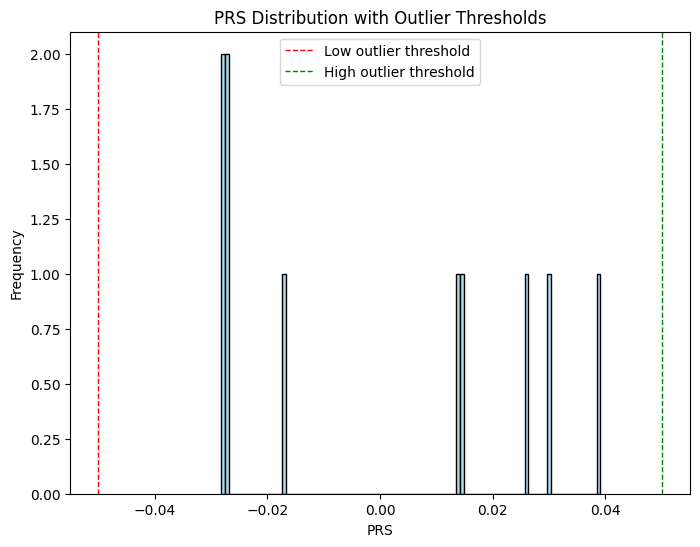

In [84]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.hist(merged_siggensummaryXprs_and_allele_freq_df['PRS'], bins=100, color='lightblue', edgecolor='black')
plt.axvline(x=-0.05, color='red', linestyle='dashed', linewidth=1, label='Low outlier threshold')
plt.axvline(x=0.05, color='green', linestyle='dashed', linewidth=1, label='High outlier threshold')
plt.title('PRS Distribution with Outlier Thresholds')
plt.xlabel('PRS')
plt.ylabel('Frequency')
plt.legend()
plt.show()
